In [1]:
import numpy as np
import pandas as pd
import math
from scipy import optimize

In [9]:
data = pd \
    .read_csv('data/logistic_regression.txt', names=['x1', 'x2', 'y']) \
    .sample(frac=1)
data.reset_index(inplace=True, drop=True)
data.head()

,x1,x2,y
0,74.492692,84.845137,1
1,90.448551,87.508792,1
2,99.315009,68.775409,1
3,76.098787,87.420570,1
4,74.248691,69.824571,1


<AxesSubplot:xlabel='x1', ylabel='x2'>

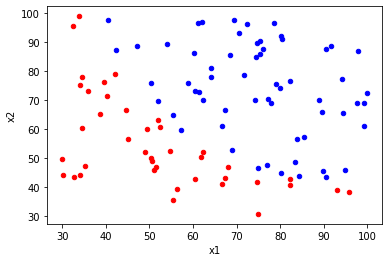

In [10]:
ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red')
data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

In [11]:
data_np = data.to_numpy()
np.random.shuffle(data_np)
data_np[0:10]

array([[99.27252693, 60.999031  ,  1.        ],
       [62.27101367, 69.95445795,  1.        ],
       [64.03932042, 78.03168802,  1.        ],
       [34.52451385, 60.39634246,  0.        ],
       [44.66826172, 66.45008615,  0.        ],
       [45.08327748, 56.31637178,  0.        ],
       [53.97105215, 89.20735014,  1.        ],
       [75.47770201, 90.424539  ,  1.        ],
       [62.0730638 , 96.76882412,  1.        ],
       [75.02474557, 46.55401354,  1.        ]])

In [24]:
def extract(data_np, start, end):
    X = None
    y = None
    n = data_np.shape[1]
    for i in range(start, end):
        if X is None:
            X = data_np[i, 0:(n-1)].reshape(1, n - 1)                      
            y = data_np[i, n-1].reshape(1, 1)
        else:
            X = np.concatenate((X, data_np[i, 0:(n-1)].reshape(1, n - 1)))  
            y = np.concatenate((y, data_np[i, n-1].reshape(1, 1)))
    return X, y

def expand(X, p):
    p = p + 1
    m = X.shape[0]
    n = X.shape[1]
    result = np.concatenate((
        np.ones((m, 1)),
        X
    ), axis=1)
    
    pv = [0] * n
    while True:
        r = 1
        sumof = 0
        for i in range(0, n):
            pv[i] = pv[i] + r
            r = pv[i] // p
            pv[i] = pv[i] % p
            sumof = sumof + pv[i]
        if r > 0:
            break
        if sumof < 2:
            continue
        toadd = None
        #print(pv)
        for i in range(0, n):
            if pv[i] < 1:
                continue
            temp = np.power(X[:, i], pv[i]).reshape(m, 1)
            if toadd is None:
                toadd = temp
            else:
                toadd = toadd + temp
        result = np.concatenate((
            result,
            toadd
        ), axis=1)
    return result
    

def cost_fn(theta, X, y, lamb):
    # Note: np.multiply performs element-wise multiplication instead of matrix multiplication
    # Note: np.matmul performs matrix multiplication
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    
    h = 1 / (1 + np.exp(-np.matmul(X, Theta)))
    result = (np.matmul(y.T, np.log(h)) + np.matmul(1 - y.T, 1 - h))[0,0] / (-m)
    result = result + (lamb / (2 * m)) * (np.sum(np.multiply(Theta, Theta)) - math.pow(Theta[0,0], 2))
    
    return result

def gradient_fn(theta, X, y, lamb):
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    h = 1 / (1 + np.exp(-np.matmul(X, Theta)))
    result = (np.matmul(X.T, (h - y)) / m)
    
    lamb_vector = np.ones((n, 1))
    lamb_vector[0, 0] = 0
    
    result = result + (lamb / m) * np.multiply(lamb_vector, Theta)
    
    return result.reshape(n)

def solve(X, y, lamb):
    n = X.shape[1]
    result = optimize.minimize(
        lambda theta: cost_fn(theta, X, y, lamb),
        jac=lambda theta: gradient_fn(theta, X, y, lamb),
        x0=np.array([0] * n),
        method='BFGS')
    return result.x.reshape(n, 1)

def select_model(data_np, max_p):
    m = data_np.shape[0]
    Xtrain, ytrain = extract(data_np, 0, math.ceil(m*0.6))
    Xcv, ycv = extract(data_np, math.ceil(m*0.6), math.ceil(m*0.8))
    Xtest, ytest = extract(data_np, math.ceil(m*0.8),m)
    df = None
    for p in range(1, max_p):
        Xtrain_ex = expand(Xtrain, p)
        Xcv_ex = expand(Xcv, p)
        theta = solve(Xtrain_ex, ytrain, 0)
        cost = cost_fn(theta, Xcv_ex, ycv, 0)
        if df is None:
            df = pd.DataFrame([[p, cost]])
        else:
            df = df.append(pd.DataFrame([[p, cost]]))
    df.plot.line(x=0, y=1)
        

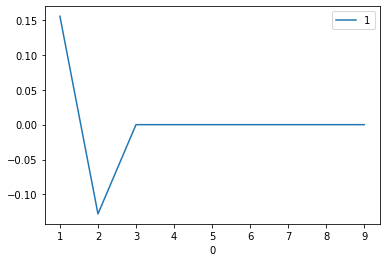

In [28]:
select_model(data_np, 10)

In [32]:
P = 2

In [47]:
def plot_model_2_upper(theta, start, end, step, ax=None):
    count = math.floor((end - start) / step)
    df = pd.DataFrame(index=range(0, count), columns=['x1', 'x2'])
    
    for i in range(0, count):
        x1 = start + step * i
        a = theta[8,0]*math.pow(x1,2) + theta[7,0]*x1 + theta[6,0]
        b = theta[5,0]*math.pow(x1,2) + theta[4,0]*x1 + theta[2,0]
        c = theta[3,0]*math.pow(x1,2) + theta[1,0]*x1 + theta[0,0]
        d = math.pow(b, 2) - 4 * a * c
        if d >= 0:
            x2 = (-b + math.sqrt(d)) / (2 * a)
            df.loc[i] = [x1, x2]
        
    return df.plot.line(x='x1', y='x2', c='g', ax=ax)


def plot_model_2_lower(theta, start, end, step, ax=None):
    count = math.floor((end - start) / step)
    df = pd.DataFrame(index=range(0, count), columns=['x1', 'x2'])
    
    for i in range(0, count):
        x1 = start + step * i
        a = theta[8,0]*math.pow(x1,2) + theta[7,0]*x1 + theta[6,0]
        b = theta[5,0]*math.pow(x1,2) + theta[4,0]*x1 + theta[2,0]
        c = theta[3,0]*math.pow(x1,2) + theta[1,0]*x1 + theta[0,0]
        d = math.pow(b, 2) - 4 * a * c
        if d >= 0:
            x2 = (-b - math.sqrt(d)) / (2 * a)
            df.loc[i] = [x1, x2]
        
    return df.plot.line(x='x1', y='x2', c='g', ax=ax)


def plot_model_2(data, data_np):
    m = data_np.shape[0]
    X, y = extract(data_np, 0, m)
    #X = expand(X, 2)
    theta = solve(X, y, 0)
    x1_min = data['x1'].min()
    x1_max = data['x1'].max()

    yh = 1 / (1 + np.exp(-np.matmul(X, theta)))
    print(yh)
    data['y^'] = yh
    
    #ax = plot_model_2_upper(theta, x1_min, x1_max, 1)
    #ax = plot_model_2_lower(theta, x1_min, x1_max, 1, ax=ax)
    ax = None
    ax = data[data['y^'] >= 0.5].plot.scatter(x='x1', y='x2', c='red', ax=ax)
    ax = data[data['y^'] < 0.5].plot.scatter(x='x1', y='x2', c='blue', ax=ax)
    return ax
    
def plot_model(data, data_np, P):
    if P == 2:
        ax = plot_model_2(data, data_np)
        #ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red', ax=ax)
        #data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

[[0.86731615]
 [0.77603385]
 [0.78423002]
 [0.67553658]
 [0.71602005]
 [0.713273  ]
 [0.75689105]
 [0.82021724]
 [0.78486319]
 [0.80530619]
 [0.80304202]
 [0.74290819]
 [0.80009126]
 [0.84276494]
 [0.86922716]
 [0.81811024]
 [0.78501232]
 [0.86046984]
 [0.84718147]
 [0.78639114]
 [0.83337691]
 [0.84785963]
 [0.69380928]
 [0.80610337]
 [0.7904079 ]
 [0.81858625]
 [0.74121819]
 [0.77545962]
 [0.7448846 ]
 [0.71387395]
 [0.79966291]
 [0.82820334]
 [0.72905076]
 [0.81059053]
 [0.85451878]
 [0.85417029]
 [0.76030134]
 [0.84853828]
 [0.85521287]
 [0.7018804 ]
 [0.75213946]
 [0.8710832 ]
 [0.77431127]
 [0.73066327]
 [0.68379364]
 [0.74064127]
 [0.78563671]
 [0.75629095]
 [0.81097873]
 [0.74526277]
 [0.8230634 ]
 [0.8328621 ]
 [0.76754418]
 [0.65301994]
 [0.73415905]
 [0.73224118]
 [0.6512798 ]
 [0.83274607]
 [0.66071071]
 [0.82092368]
 [0.81373437]
 [0.74004638]
 [0.78187885]
 [0.67245896]
 [0.82009293]
 [0.80663256]
 [0.83153009]
 [0.76943564]
 [0.78999605]
 [0.71186831]
 [0.77156034]
 [0.85

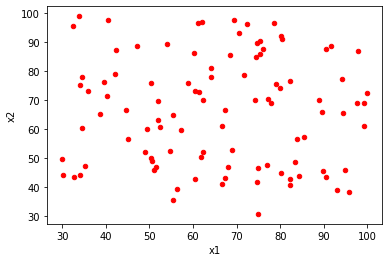

In [48]:
plot_model(data, data_np, P)